# 1.import data

In [7]:
import numpy as np
train_seismic = np.load('train/train_seismic.npy')
train_labels = np.load('train/train_labels.npy')
test_seismic = np.load('test_once/test1_seismic.npy')
test_labels = np.load('test_once/test1_labels.npy')

The value of pixels in edge will be zero if you expand the section's edge

In [8]:
train_labels+=1
test_labels+=1

# 2.Make the patches of 3-D seismic data

## Define the function

In [9]:
def seispatch_2d(section,patch_size,os_x=0,os_y=0,show=0,colors="Dark2"):
    '''
    section :the 2-D seismic data
    patch_size :the size of patches
    os_x/_y: the length of overlap 
    show: 1:visualization
    colors：if show==1; label:"Dark2"; seismic:"seismic" or "Greys"
    '''
    m1,m2 = section.shape                            
    n1,n2 = patch_size,patch_size              

    c1 = int(np.round((m1+os_y)/(n1-os_y)+0.5))   
    c2 = int(np.round((m2+os_x)/(n2-os_x)+0.5))-2  #-2 for os=128,

    p1 = (n1-os_y)*c1+os_y   #expand the edge
    p2 = (n2-os_x)*c2+os_x   

    img_pad   = np.zeros((p1,p2),dtype=np.single)
    img_pad[0:m1,0:m2]=section
    img_patch = np.zeros((n1,n2),dtype=np.single)

    i=0
    result=np.zeros((c1*c2,n1,n2),dtype=np.single)  #结果储存进矩阵
    
    for k1 in range(c1):
        for k2 in range(c2):
            b1 = k1*(n1-os_y)  #开始：n1-os=116
            e1 = b1+n1          
            b2 = k2*(n2-os_x)
            e2 = b2+n2                   
            img_patch=img_pad[b1:e1,b2:e2]
            result[i,]=img_patch
            i+=1
            
            if show == 1:
                import matplotlib.pyplot as plt
                plt.subplot(c1,c2,i)
                imgplot1 = plt.imshow(img_patch,cmap=colors,interpolation='nearest')            
    return result

def extract_2d_from_3d(seismic_3d,axis=0,patch_size=128,os_x=0,os_y=0):
    '''
    seismic_3d :the 3-D seismic data
    axis :0:patch from inline; 1:xline
    '''
    for i in range(np.shape(seismic_3d)[axis]):
        line=seispatch_2d(np.transpose(seismic_3d[i]),patch_size,os_x,os_y)
        if i == 0:
            c = line
        else:
            c=np.vstack((c,line))
    return c

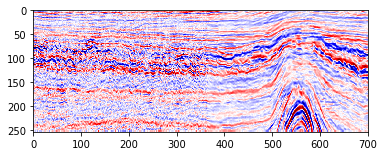

In [10]:
import matplotlib.pyplot as plt
plt.imshow(np.transpose(train_seismic[400]),cmap="seismic_r")

(5, 256, 256)

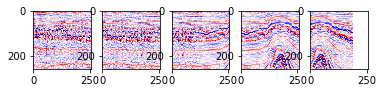

In [11]:
line1=seispatch_2d(np.transpose(train_seismic[400]),256,128,0,show=1,colors="seismic_r")
line1.shape

## make training data sets

In [12]:
sei_patch = extract_2d_from_3d(train_seismic,patch_size=256,os_x=128,os_y=0)
lab_patch = extract_2d_from_3d(train_labels,patch_size=256,os_x=128,os_y=0)
lab_patch.shape

(2005, 256, 256)

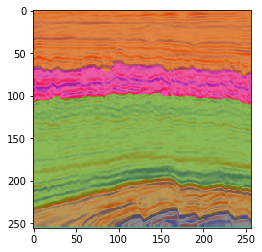

In [13]:
n=965
plt.imshow(sei_patch[n],cmap="seismic_r")
plt.imshow(lab_patch[n],cmap="Dark2",alpha=0.75)

## make the validation data sets

In [14]:
test_sei_patch = extract_2d_from_3d(test_seismic,patch_size=256,os_x=128,os_y=0)
test_lab_patch = extract_2d_from_3d(test_labels,patch_size=256,os_x=128,os_y=0)
test_sei_patch.shape

(1000, 256, 256)

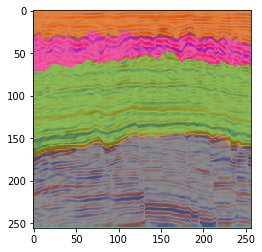

In [15]:
n=20
plt.imshow(test_sei_patch[n],cmap="seismic_r")
plt.imshow(test_lab_patch[n],cmap="Dark2",alpha=0.75)

# 3.U-net architecture 

In [16]:
import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras
from keras import losses

def unet(pretrained_weights = None,input_size = (256,256,1)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, (3,3), padding='same')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation('relu')(conv1)
    conv1 = Conv2D(64, (3,3), padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation('relu')(conv1)
    pool1 = MaxPooling2D(pool_size=(2,2))(conv1)

    conv2 = Conv2D(128, (3,3),padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Activation('relu')(conv2)
    conv2 = Conv2D(128, (3,3), padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    conv2 = Activation('relu')(conv2)
    pool2 = MaxPooling2D(pool_size=(2,2))(conv2)

    conv3 = Conv2D(256, (3,3), padding='same')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Activation('relu')(conv3)
    conv3 = Conv2D(256, (3,3),padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    conv3 = Activation('relu')(conv3)
    pool3 = MaxPooling2D(pool_size=(2,2))(conv3)

    conv4 = Conv2D(512, (3,3), padding='same')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Activation('relu')(conv4)
    conv4 = Conv2D(512, (3,3), padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    conv4 = Activation('relu')(conv4)

    up5 = concatenate([UpSampling2D(size=(2,2))(conv4), conv3], axis=3)
    conv5 = Conv2D(256, (3,3), padding='same')(up5)
    conv5 = BatchNormalization()(conv5)
    conv5 = Activation('relu')(conv5)
    conv5 = Conv2D(256, (3,3),padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)
    conv5 = Activation('relu')(conv5)

    up6 = concatenate([UpSampling2D(size=(2,2))(conv5), conv2], axis=3)
    conv6 = Conv2D(128, (3,3), activation='relu', padding='same')(up6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Activation('relu')(conv6)
    conv6 = Conv2D(128, (3,3), padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Activation('relu')(conv6)

    up7 = concatenate([UpSampling2D(size=(2,2))(conv6), conv1], axis=3)
    conv7 = Conv2D(64, (3,3), activation='relu', padding='same')(up7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Activation('relu')(conv7)
    conv7 = Conv2D(64, (3,3), activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Activation('relu')(conv7)

    conv8 = Conv2D(7, (1,1))(conv7)
    conv8 = BatchNormalization()(conv8)
    conv8 = Activation('sigmoid')(conv8)

    model = Model(inputs=[inputs], outputs=[conv8])
    model.compile(optimizer = Adam(lr = 1e-4), loss =losses.categorical_crossentropy, metrics = ['accuracy'])
  
    return model

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [17]:
model=unet()
model.summary()  

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 256, 256, 64) 256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 256, 256, 64) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

#  4.train

In [20]:
from keras.utils.np_utils import to_categorical
import keras

class DataGenerator(keras.utils.Sequence):
    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size
    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))
    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = to_categorical(batch_y, num_classes=7)

        return np.expand_dims(batch_x,axis=4), batch_y

training_generator=DataGenerator(x_set=sei_patch,y_set=lab_patch,batch_size=25)
validation_generator=DataGenerator(x_set=test_sei_patch,y_set=test_lab_patch,batch_size=25)

In [21]:
history = model.fit_generator(generator=training_generator,validation_data=validati on_generator,epochs=20,verbose=1)

Epoch 1/20


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  from ipykernel import kernelapp as app


81/81 [==============================] - 9759s 120s/step - loss: 1.4991 - acc: 0.7708 - val_loss: 1.4309 - val_acc: 0.7527
Epoch 2/20
81/81 [==============================] - 9761s 121s/step - loss: 1.4030 - acc: 0.9020 - val_loss: 1.4046 - val_acc: 0.8171
Epoch 3/20
81/81 [==============================] - 9758s 120s/step - loss: 1.3881 - acc: 0.9220 - val_loss: 1.4213 - val_acc: 0.8131
Epoch 4/20
81/81 [==============================] - 9715s 120s/step - loss: 1.3789 - acc: 0.9262 - val_loss: 1.4256 - val_acc: 0.8335
Epoch 5/20
81/81 [==============================] - 9719s 120s/step - loss: 1.3711 - acc: 0.9275 - val_loss: 1.4188 - val_acc: 0.8502
Epoch 6/20
81/81 [==============================] - 9723s 120s/step - loss: 1.3640 - acc: 0.9273 - val_loss: 1.4233 - val_acc: 0.8473
Epoch 7/20
81/81 [==============================] - 9719s 120s/step - loss: 1.3574 - acc: 0.9271 - val_loss: 1.4259 - val_acc: 0.8420
Epoch 8/20
81/81 [==============================] - 10161s 125s/step - lo

In [22]:
# serialize model to JSON
model_json = model.to_json()
with open("model_2D-Unet.json", "w") as js on_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model_2D-Unet.h5")

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


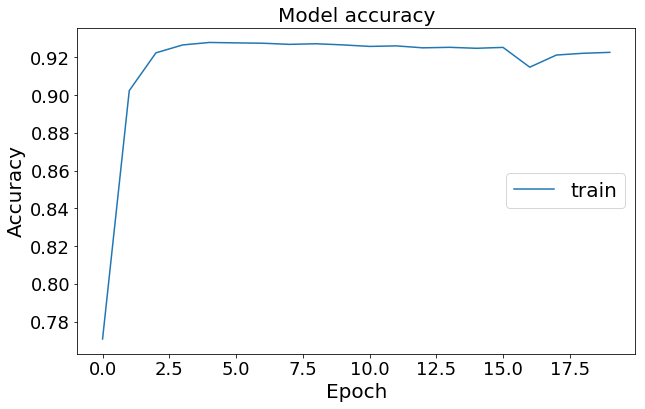

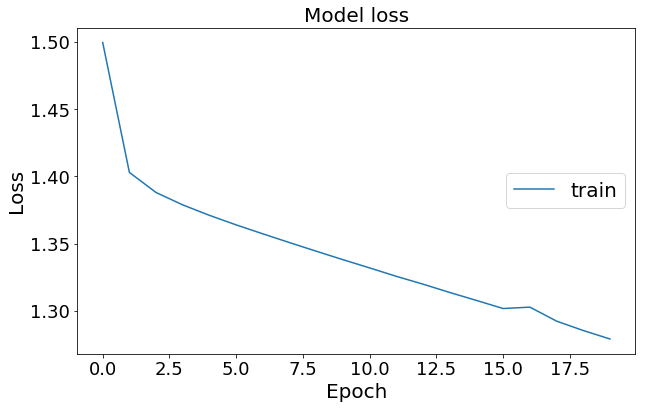

In [24]:
# list all data in history
print(history.history.keys())
fig = plt.figure(figsize=(10,6))

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.title('Model accuracy',fontsize=20)
plt.ylabel('Accuracy',fontsize=20)
plt.xlabel('Epoch',fontsize=20)
plt.legend(['train', 'test'], loc='center right',fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=18)
plt.show()

# summarize history for loss
fig = plt.figure(figsize=(10,6))
plt.plot(history.history['loss'])
plt.title('Model loss',fontsize=20)
plt.ylabel('Loss',fontsize=20)
plt.xlabel('Epoch',fontsize=20)
plt.legend(['train', 'test'], loc='center right',fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=18)
plt.show()